<center>
    <a href="https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce">
        <img src="https://storage.googleapis.com/kaggle-datasets-images/55151/105464/d59245a7014a35a35cc7f7b721de4dae/dataset-cover.png?t=2018-09-21-16-21-21" style="max-width: 300px; display: inline" alt="OpenClassrooms"/>
    </a>
</center>

<center>
    <span style="color:lightpurple; font-size: 24px; font-weight: bold;">
        PROJET DATA SCIENCE
    </span>
</center>
<br><br>
<center>
    <span style="color:black; font-size: 22px; font-weight: bold;">
        Segmenter des clients d'un site e-commerce
    </span>
</center>
<center>
    <span style="color:blue; font-size: 22px; font-weight: bold;">
        Notebook n°3 - Maintenance
    </span>
</center>
<br><br>
<center>
    <span style="color:black; font-weight: bold;">
        Ambre ROBERT
    </span>
</center>
<br><br>

Olist est une entreprise brésilienne offrant une solution pour vendre sur les marketplaces en ligne.
Afin de mettre au point des campagnes de communication pertinentes, Olist souhaite comprendre les différents types d’utilisateurs de son site. 

Dans ce contexte, le projet suivant s'intéresse au comportement et aux données personnelles de ces utilisateurs. 
L'objectif est de fournir une segmentation des clients d’Olist destinée à l’équipe Marketing afin d’améliorer la communication de l’entreprise.

Ce notebook contientient toute la partie maintenace du modèle sélectionné. 

### Librairies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import scipy.stats as stats
from scipy.stats import ks_2samp

### Style des graphiques

In [2]:
sns.set(style="whitegrid")
background_color = '#2a2e3b'
title_size = 20
label_size = 14
text_color = 'white'

Dans la suite nous effectuerons une simulation d'évolution de la stabilité du clustering sur différentes périodes.

### Importation des données

In [3]:
customers = pd.read_csv("./data/customers_ari.csv")

# 1. Table des matières
- [2. Le modèle](#2.-Le-modèle)
- [3. La maintenance](#3.-La-maintenance)
- [4. Conclusion](#4.-Conclusion)

# 1- Le modèle

Nous reprenons le modèle sélectionné dans le notebook précédent. 

In [4]:
data = customers[['customer_unique_id', 'date', 'total_price', 'delayed', 'average_number_products_per_order', 
              'time_since_last_order', 'number_of_orders']]

Le jeu de données commence en octobre 2016.

In [5]:
data['date'] = pd.to_datetime(data['date'])
data_ref = pd.DataFrame(data)

# filtrer les lignes où la date antérieur à "2018-01-01"
data_ref = data_ref[data_ref['date'] < '2018-01-01']

# pour chaque 'customer_unique_id' garder la ligne la plus récente
data_ref = data_ref.loc[data_ref.groupby('customer_unique_id')['date'].idxmax()]

<ipython-input-5-d697b31b867b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


In [6]:
log_columns = ['total_price', 'time_since_last_order']
standardize_columns = ['total_price', 'delayed', 'average_number_products_per_order', 'time_since_last_order', 
                       'number_of_orders']

for col in log_columns:
        data_ref[col] = np.log1p(data_ref[col])

scaler = StandardScaler()
data_ref[standardize_columns] = scaler.fit_transform(data_ref[standardize_columns])

In [7]:
data_ref_red = data_ref.drop(['customer_unique_id', 'date'], axis=1)

model = KMeans(n_clusters=4, random_state=42)
model.fit(data_ref_red)
model_labels_ref = model.labels_
data_ref["Cluster"] = model.labels_

# 2- La maintenance

On évalue la stabilité des clusters créés à l’aide de l’algorithme k-means. Pour cela on calcule le score Adjusted Rand Index (ARI), qui mesure la similarité entre les clusters obtenus à différents moments dans le temps.

In [8]:
def cluster_evolution(data, data_ref, results, date_hist, title, model, model_labels_ref):

    date = []
    ari_score = []
    
    
    df = data.copy()
    df_date = df[df["date"] < date_hist]

    df_date = df_date[df_date["customer_unique_id"].isin(
                                   data_ref["customer_unique_id"])]
    #df_date = df_date.set_index("customer_unique_id")

    df_date = df_date.loc[df_date.groupby('customer_unique_id')['date'].idxmax()]
    
    
    log_columns = ['total_price', 'time_since_last_order']
    for col in log_columns:
        df_date[col] = np.log1p(df_date[col])
        
    
    standardize_columns = ['total_price', 'delayed', 'average_number_products_per_order', 
                           'time_since_last_order', 'number_of_orders']
    scaler = StandardScaler()
    df_date[standardize_columns] = scaler.fit_transform(df_date[standardize_columns])
    
    
    df_date_red = df_date.drop(['customer_unique_id', 'date'], axis=1)
    model.fit(df_date_red)
    model_labels = model.labels_
    df_date["Cluster"] = model.labels_
    
    
    ARI = metrics.adjusted_rand_score(model_labels_ref,
                                             model_labels)

    date.append(date_hist)
    ari_score.append(ARI)

    results = pd.concat([results, (pd.DataFrame({
                                            "Period": [title],
                                            "Date" : date,
                                            "ARI": ARI}))], axis=0)

    df_date = df_date.reset_index()

    return results, df_date

Nous allons étudier la stabilité des clusters pour notre modèle k-means en découpant sur des périodes de 15 jours à partir de la date choisie (1er janvier 2018). 
On créer un seil à 0.7 pour le score ARI.

Le score ARI est descendu sous 0.7 à la période 5. Arrêt du calcul.


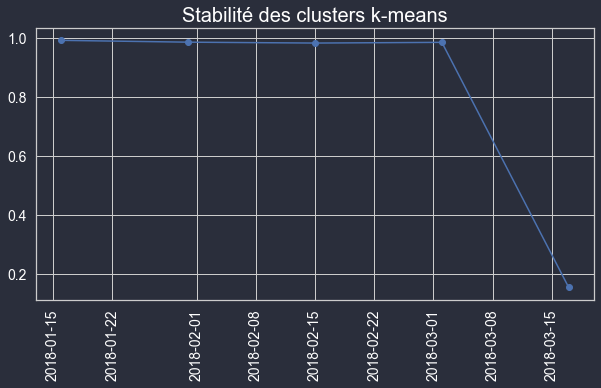

In [9]:
periods = pd.date_range(start='2018-01-01', end='2018-09-01', freq='15D')
df_ari_results = pd.DataFrame()

threshold_ari = 0.7 #seuil ARI

for i, date_hist in enumerate(periods[1:], start=1):
    df_ari_results, _ = cluster_evolution(data, data_ref, df_ari_results, date_hist, 
                                          f"Period {i}", model, model_labels_ref)
    
    if df_ari_results["ARI"].iloc[-1] < threshold_ari:
        print(f"Le score ARI est descendu sous {threshold_ari} à la période {i}. Arrêt du calcul.")
        break  # Arrêter la boucle si ARI est inférieur au seuil

plt.figure(figsize=(10, 5))
plt.gca().set_facecolor(background_color)
plt.plot(df_ari_results["Date"], df_ari_results["ARI"], "o-")
plt.xticks(color=text_color, fontsize=label_size, rotation=90)
plt.yticks(color=text_color, fontsize=label_size)
plt.title("Stabilité des clusters k-means", fontsize=title_size, color=text_color)
plt.gcf().set_facecolor(background_color)
plt.show()

<Figure size 720x360 with 0 Axes>

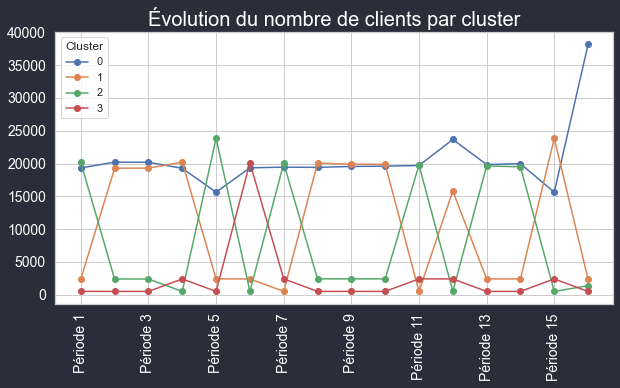

In [10]:
df_cluster_evolution = pd.DataFrame()
for i, date_hist in enumerate(periods[1:], start=1):
    _, df_period = cluster_evolution(data, data_ref, df_ari_results, date_hist, f"Period {i}", model, model_labels_ref)
    cluster_counts = df_period['Cluster'].value_counts().rename(f'Période {i}')
    df_cluster_evolution = pd.concat([df_cluster_evolution, cluster_counts], axis=1)

df_cluster_evolution = df_cluster_evolution.T

plt.figure(figsize=(10, 5))
df_cluster_evolution.plot(kind='line', marker='o', figsize=(10, 5))
plt.xticks(rotation=90, color=text_color, fontsize=label_size)
plt.yticks(color=text_color, fontsize=label_size)
plt.title("Évolution du nombre de clients par cluster", fontsize=title_size, color=text_color)
plt.gcf().set_facecolor(background_color)
plt.legend(title='Cluster')
plt.show()

## Conclusion

Au vu de l'évolution bi-mensuelle des clusters, de l'évolution du score ARI, la mise à jour devrait être faite au bout de 2 mois / 2 mois et demi pour garantir une stabilité optimale.

## 3- Évolution des features numériques dans le temps

Nous allons observer la distribution de nos variables numériques dans les données utilisées pour l'entrainement initial et les prédictions ultérieures.

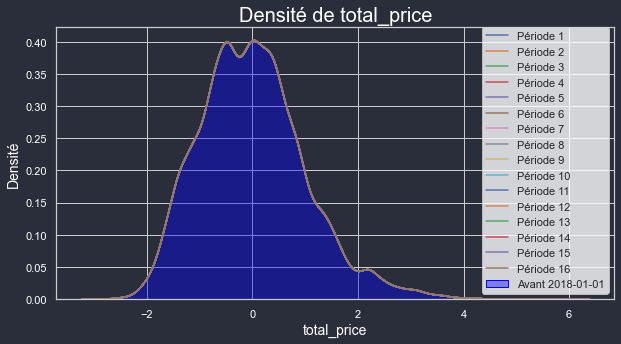

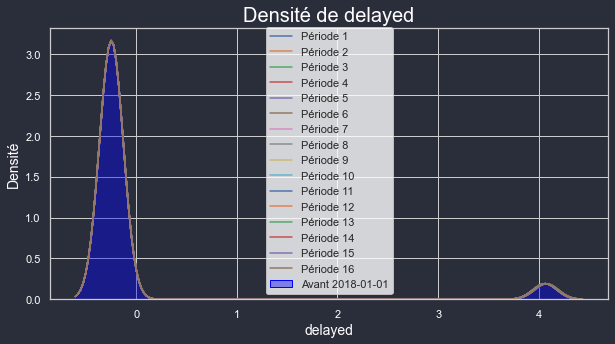

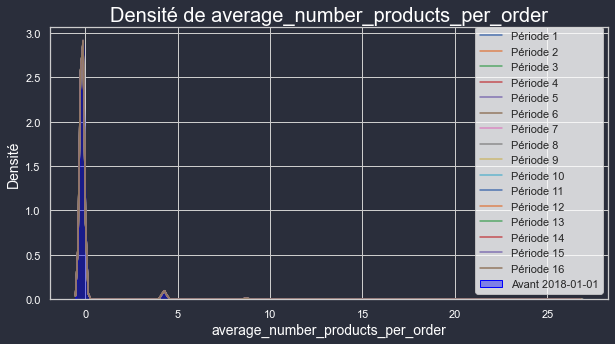

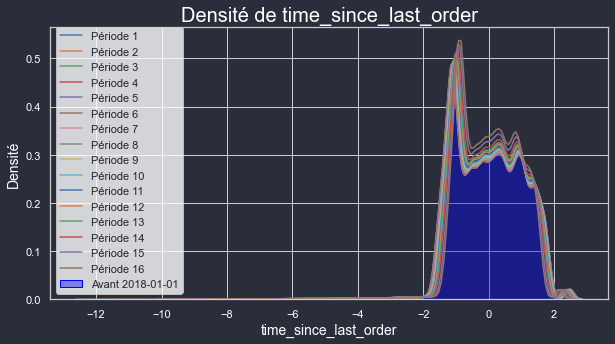

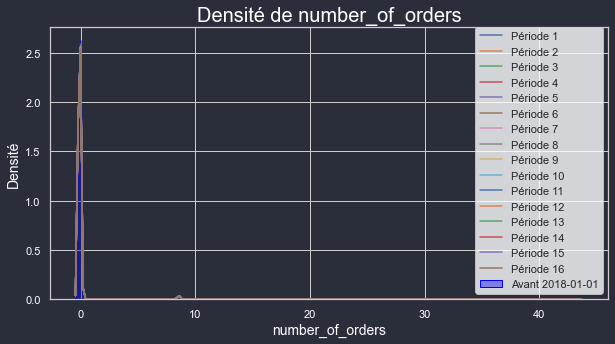

In [11]:
variables = ['total_price', 'delayed', 'average_number_products_per_order', 'time_since_last_order', 'number_of_orders']

for var in variables:
    plt.figure(figsize=(10, 5))
    plt.gca().set_facecolor(background_color)
    
    sns.kdeplot(data_ref[var], label='Avant 2018-01-01', color='blue', fill=True, alpha=0.4)
    
    for i, date_hist in enumerate(periods[1:], start=1):
        _, df_period = cluster_evolution(data, data_ref, df_ari_results, date_hist, f"Period {i}", model, model_labels_ref)
        sns.kdeplot(df_period[var], label=f'Période {i}', alpha=0.3)
    
    plt.title(f'Densité de {var}', fontsize=title_size, color=text_color)
    plt.xlabel(var, fontsize=label_size, color=text_color)  
    plt.ylabel("Densité", fontsize=label_size, color=text_color)  
    plt.tick_params(axis='x', colors=text_color)  
    plt.tick_params(axis='y', colors=text_color)  
    plt.legend()
    plt.gcf().set_facecolor(background_color)
    plt.show()

<Figure size 720x432 with 0 Axes>

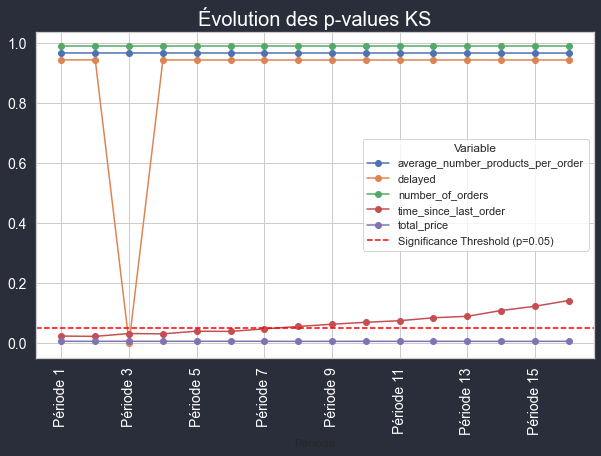

In [12]:
# Test de Kolmogorov-Smirnov
ks_results = []

for i, date_hist in enumerate(periods[1:], start=1):
    _, df_period = cluster_evolution(data, data_ref, df_ari_results, date_hist, f"Period {i}", model, model_labels_ref)
    
    for var in variables:
        base_data = data_ref[var]
        test_stat, p_value = ks_2samp(base_data, df_period[var])
        ks_results.append({"Période": f"Période {i}", "Variable": var, "KS Stat": test_stat, "p-valeur": p_value})

df_ks_results = pd.DataFrame(ks_results)

df_ks_results['KS Stat'] = pd.to_numeric(df_ks_results['KS Stat'], errors='coerce')

df_ks_results['Période'] = pd.Categorical(df_ks_results['Période'], categories=[f"Période {i}" for i in range(1, len(periods))], ordered=True)
df_ks_results_sorted = df_ks_results.sort_values(by='Période')

df_ks_stats_sorted = df_ks_results_sorted.pivot_table(index='Période', columns='Variable', values='KS Stat')

plt.figure(figsize=(10, 6))
df_ks_stats_sorted.plot(marker='o', figsize=(10, 6))
plt.title("Évolution des p-values KS", fontsize=title_size, color=text_color)
plt.gcf().set_facecolor(background_color)
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xticks(rotation=90, color=text_color, fontsize=label_size)
plt.yticks(color=text_color, fontsize=label_size)
plt.legend(title='Variable')
plt.show()

Au vue des résultats, la stratégie pourrait être de réentraîner le modèle à des intervalles réguliers, par exemple tous les 1 à 2 mois.